In [3]:
import warnings
warnings.filterwarnings("ignore")  # Consider specifying warning types
import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score  # Corrected
)
from imblearn.over_sampling import RandomOverSampler
import accelerate  # Remove if not used
import evaluate  # Remove if not used
from datasets import Dataset, Image, ClassLabel  # Corrected
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)

In [4]:
# !pip install accelerate
# !pip install evaluate
# !pip install transformers
# !pip install tf-keras
# !pip install torchvision


In [5]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import zipfile
from pathlib import Path

zip_path = Path('/content/drive/MyDrive/Dataset.zip')
extract_to = Path('/content/Deepfake Image Detection')  # extracted here

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extracted to:", extract_to)


Extracted to: /content/Deepfake Image Detection


In [9]:
from pathlib import Path
import pandas as pd

file_names = []
labels = []

# Set the correct base path to where Dataset is located in Colab
base_path = Path("/content/Deepfake Image Detection/Dataset")

# Traverse train, test, validate folders
for file in sorted(base_path.rglob("*.*")):
    if file.is_file():
        parts = file.parts
        # We expect label to be the parent folder name: real or fake
        label = file.parent.name
        file_names.append(str(file))
        labels.append(label)

# Create DataFrame
df = pd.DataFrame({'image': file_names, 'label': labels})

# Print summary
print("The number of files and labels:", len(file_names), len(labels))
print("The shape of the DataFrame:", df.shape)

# Show a few rows
df.head()


The number of files and labels: 190335 190335
The shape of the DataFrame: (190335, 2)


,image,label
0,/content/Deepfake Image Detection/Dataset/Test...,Fake
1,/content/Deepfake Image Detection/Dataset/Test...,Fake
2,/content/Deepfake Image Detection/Dataset/Test...,Fake
3,/content/Deepfake Image Detection/Dataset/Test...,Fake
4,/content/Deepfake Image Detection/Dataset/Test...,Fake


In [10]:
df.head()

,image,label
0,/content/Deepfake Image Detection/Dataset/Test...,Fake
1,/content/Deepfake Image Detection/Dataset/Test...,Fake
2,/content/Deepfake Image Detection/Dataset/Test...,Fake
3,/content/Deepfake Image Detection/Dataset/Test...,Fake
4,/content/Deepfake Image Detection/Dataset/Test...,Fake


In [11]:
df['label'].unique()

array(['Fake', 'Real'], dtype=object)

In [12]:
y = df[['label']]

df = df.drop(['label'], axis=1)
ros = RandomOverSampler (random_state=83)

df, y_resampled = ros.fit_resample(df, y)

del y
df['label'] = y_resampled

del y_resampled

gc.collect()

print(df.shape)

(190402, 2)


In [13]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())

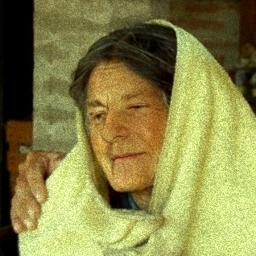

In [14]:
dataset[0]["image"]

In [15]:
labels_subset = labels[:5]
print(labels_subset)

['Fake', 'Fake', 'Fake', 'Fake', 'Fake']


In [16]:
labels_list = ['Real', 'Fake']

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id [label] = i
    id2label[i] = label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


In [17]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=0.4, shuffle= True, stratify_by_column="label")

train_data = dataset['train']
test_data = dataset['test']

Map:   0%|          | 0/190402 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190402 [00:00<?, ? examples/s]

In [18]:
model_str = "dima806/deepfake_vs_real_image_detection"

processor = ViTImageProcessor.from_pretrained(model_str)

image_mean, image_std = processor.image_mean, processor.image_std

size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        Resize ((size, size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),
        ToTensor(),
        normalize
    ]
)

_val_transforms = Compose(
    [
        Resize((size,size)),
        ToTensor(),
        normalize
    ]
)

def train_transforms(examples) :
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples) :
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples


preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Size:  224


In [19]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [20]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [21]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels = len(labels_list))

model.config.id2label = id2label
model.config.label2id = label2id

print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

85.800194


In [22]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return{
        "accuracy" : acc_score
    }

In [23]:
from transformers import TrainingArguments

metric_name = "accuracy"
model_name = "deepfake_vs_real_image_detection"
num_train_epochs = 2

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    # The 'evaluation_strategy' argument is replaced with 'eval_strategy'
    eval_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor
)

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.047500,0.022498,0.992595
2,0.053300,0.022233,0.992660


TrainOutput(global_step=7142, training_loss=0.05221596674837675, metrics={'train_runtime': 10184.7216, 'train_samples_per_second': 22.434, 'train_steps_per_second': 0.701, 'total_flos': 1.770552477112121e+19, 'train_loss': 0.05221596674837675, 'epoch': 2.0})

In [26]:
trainer.evaluate()

{'eval_loss': 0.022233307361602783,
 'eval_accuracy': 0.9926602854479327,
 'eval_runtime': 944.6653,
 'eval_samples_per_second': 80.622,
 'eval_steps_per_second': 10.079,
 'epoch': 2.0}

In [27]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.022233307361602783, 'test_accuracy': 0.9926602854479327, 'test_runtime': 951.1133, 'test_samples_per_second': 80.076, 'test_steps_per_second': 10.01}


Accuracy: 0.9927
F1 Score: 0.9927


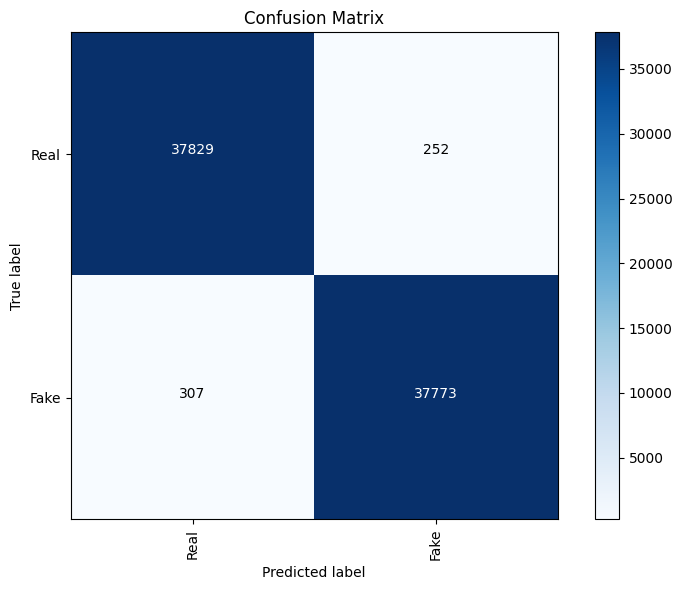


Classification report:

              precision    recall  f1-score   support

        Real     0.9919    0.9934    0.9927     38081
        Fake     0.9934    0.9919    0.9927     38080

    accuracy                         0.9927     76161
   macro avg     0.9927    0.9927    0.9927     76161
weighted avg     0.9927    0.9927    0.9927     76161



In [29]:

# Extract predictions and true labels
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# Define labels (make sure it's defined before use)
labels_list = ['Real', 'Fake']  # Update if you have different class names

# Confusion matrix plotting function
def plot_confusion_matrix(cm, classes, title="Confusion Matrix", cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Compute accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Classification report
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))


In [30]:
trainer.save_model()

In [31]:
from transformers import pipeline

pipe = pipeline('image-classification', model=model_name, device=0)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0
